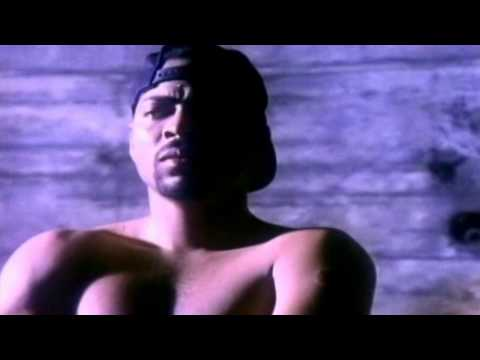

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("9k1XyvwM4no", width=600, height=350)

In [2]:
 %%writefile ensemble_submissions.py
#!/usr/bin/env python3
"""
Ensemble Optimizer
https://www.kaggle.com/code/hvanphucs112/bbox3-ensemble-update
"""

import csv
import math
import glob
import os
from collections import defaultdict
from typing import Dict, List, Tuple

# Tree shape constants (from C++ code)
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

def get_polygon_bounds(cx: float, cy: float, deg: float) -> Tuple[float, float, float, float]:
    """Calculate bounding box of rotated tree polygon"""
    rad = deg * math.pi / 180.0
    s = math.sin(rad)
    c = math.cos(rad)
    
    x_coords = []
    y_coords = []
    
    for i in range(len(TX)):
        x = TX[i] * c - TY[i] * s + cx
        y = TX[i] * s + TY[i] * c + cy
        x_coords.append(x)
        y_coords.append(y)
    
    return min(x_coords), max(x_coords), min(y_coords), max(y_coords)

def calculate_score(trees: List[Tuple[int, float, float, float]]) -> Tuple[float, float, float, float]:
    """
    Calculate score for a configuration
    Returns: (score, side, width, height)
    """
    if not trees:
        return float('inf'), 0, 0, 0
    
    global_x_min = float('inf')
    global_x_max = float('-inf')
    global_y_min = float('inf')
    global_y_max = float('-inf')
    
    for idx, cx, cy, deg in trees:
        x_min, x_max, y_min, y_max = get_polygon_bounds(cx, cy, deg)
        global_x_min = min(global_x_min, x_min)
        global_x_max = max(global_x_max, x_max)
        global_y_min = min(global_y_min, y_min)
        global_y_max = max(global_y_max, y_max)
    
    width = global_x_max - global_x_min
    height = global_y_max - global_y_min
    side = max(width, height)
    score = side * side / len(trees)
    
    return score, side, width, height

def load_submission(filepath: str) -> Dict[int, List[Tuple[int, float, float, float]]]:
    """
    Load submission file
    Returns: dict mapping n -> list of (idx, x, y, deg)
    """
    configurations = defaultdict(list)
    
    try:
        with open(filepath, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                # Parse id
                id_parts = row['id'].split('_')
                n = int(id_parts[0])
                idx = int(id_parts[1])
                
                # Parse coordinates (remove 's' prefix if present)
                x = float(row['x'].replace('s', ''))
                y = float(row['y'].replace('s', ''))
                deg = float(row['deg'].replace('s', ''))
                
                configurations[n].append((idx, x, y, deg))
        
        # Sort by index
        for n in configurations:
            configurations[n].sort(key=lambda t: t[0])
        
        return dict(configurations)
    
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return {}

def analyze_submission(filepath: str, configurations: Dict[int, List]) -> Dict[int, Tuple]:
    """
    Analyze a submission file
    Returns: dict mapping n -> (score, side, width, height)
    """
    results = {}
    
    for n, trees in configurations.items():
        if len(trees) != n:
            print(f"  WARNING: n={n} has {len(trees)} trees (expected {n})")
            continue
        
        score, side, width, height = calculate_score(trees)
        results[n] = (score, side, width, height)
    
    return results

def create_ensemble(submissions: Dict[str, Dict[int, List]]) -> Dict[int, Tuple[List, str, float]]:
    """
    Create ensemble by selecting best configuration for each n
    Returns: dict mapping n -> (best_trees, source_file, score)
    """
    ensemble = {}
    
    # Get all n values
    all_n = set()
    for configs in submissions.values():
        all_n.update(configs.keys())
    
    # For each n, find best configuration
    for n in sorted(all_n):
        best_score = float('inf')
        best_trees = None
        best_source = None
        
        for filepath, configs in submissions.items():
            if n not in configs:
                continue
            
            trees = configs[n]
            if len(trees) != n:
                continue
            
            score, side, width, height = calculate_score(trees)
            
            if score < best_score:
                best_score = score
                best_trees = trees
                best_source = filepath
        
        if best_trees:
            ensemble[n] = (best_trees, best_source, best_score)
    
    return ensemble

def save_ensemble(ensemble: Dict[int, Tuple], output_path: str):
    """Save ensemble submission"""
    with open(output_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'x', 'y', 'deg'])
        
        for n in sorted(ensemble.keys()):
            trees, _, _ = ensemble[n]
            for idx, x, y, deg in trees:
                row_id = f"{n:03d}_{idx}"
                writer.writerow([row_id, f's{x:.17f}', f's{y:.17f}', f's{deg:.17f}'])

def print_comparison(submissions: Dict[str, Dict[int, List]], ensemble: Dict[int, Tuple]):
    """Print detailed comparison"""
    print("\n" + "="*80)
    print("DETAILED COMPARISON BY N")
    print("="*80)
    
    all_n = sorted(set(
        n for configs in submissions.values() 
        for n in configs.keys()
    ))
    
    # Prepare data for each n
    for n in all_n:
        print(f"\n{'─'*80}")
        print(f"n = {n}")
        print(f"{'─'*80}")
        
        # Collect scores from all submissions
        scores_data = []
        for filepath, configs in submissions.items():
            if n in configs and len(configs[n]) == n:
                score, side, width, height = calculate_score(configs[n])
                basename = os.path.basename(filepath)
                scores_data.append((basename, score, side))
        
        # Sort by score
        scores_data.sort(key=lambda x: x[1])
        
        # Print table
        print(f"{'Source':<30} {'Score':<20} {'Side':<20} {'Status'}")
        print(f"{'-'*30} {'-'*20} {'-'*20} {'-'*10}")
        
        for i, (source, score, side) in enumerate(scores_data):
            status = "✅ BEST" if i == 0 else ""
            print(f"{source:<30} {score:<20.15f} {side:<20.15f} {status}")
        
        # Show ensemble choice
        if n in ensemble:
            _, best_source, best_score = ensemble[n]
            print(f"\n→ Ensemble choice: {os.path.basename(best_source)} (score: {best_score:.15f})")
        
        # Calculate improvement range
        if len(scores_data) > 1:
            worst_score = scores_data[-1][1]
            best_score = scores_data[0][1]
            improvement = (worst_score - best_score) / worst_score * 100
            print(f"→ Improvement range: {improvement:.4f}%")

def print_summary(submissions: Dict[str, Dict[int, List]], ensemble: Dict[int, Tuple]):
    """Print summary statistics"""
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    
    # Per-file statistics
    print("\nPer-file statistics:")
    print(f"{'File':<30} {'Total n':<10} {'Avg Score':<20} {'Best Count'}")
    print(f"{'-'*30} {'-'*10} {'-'*20} {'-'*10}")
    
    for filepath, configs in sorted(submissions.items()):
        basename = os.path.basename(filepath)
        
        # Calculate average score
        total_score = 0
        count = 0
        for n, trees in configs.items():
            if len(trees) == n:
                score, _, _, _ = calculate_score(trees)
                total_score += score
                count += 1
        
        avg_score = total_score / count if count > 0 else 0
        
        # Count how many times this file was chosen as best
        best_count = sum(1 for _, source, _ in ensemble.values() 
                        if source == filepath)
        
        print(f"{basename:<30} {count:<10} {avg_score:<20.10f} {best_count}")
    
    # Ensemble statistics
    print("\n" + "-"*80)
    print("Ensemble statistics:")
    
    total_score = sum(score for _, _, score in ensemble.values())
    avg_score = total_score / len(ensemble) if ensemble else 0

   
    print(f"  Total n values: {len(ensemble)}")
    print(f"  Total score: {total_score}")
    print(f"  Average score:  {avg_score:.10f}")
    
    # Count improvements
    print("\nSource distribution in ensemble:")
    source_counts = defaultdict(int)
    for _, source, _ in ensemble.values():
        basename = os.path.basename(source)
        source_counts[basename] += 1
    
    for source, count in sorted(source_counts.items(), key=lambda x: -x[1]):
        pct = count / len(ensemble) * 100
        print(f"  {source:<30} {count:>3} / {len(ensemble)} ({pct:>5.1f}%)")

def print_highlights(ensemble: Dict[int, Tuple]):
    """Print highlights - best and worst scores"""
    print("\n" + "="*80)
    print("HIGHLIGHTS")
    print("="*80)
    
    # Sort by score
    sorted_n = sorted(ensemble.items(), key=lambda x: x[1][2])
    
    print("\n🏆 TOP 10 BEST SCORES:")
    print(f"{'n':<5} {'Score':<20} {'Source'}")
    print(f"{'-'*5} {'-'*20} {'-'*40}")
    for i, (n, (_, source, score)) in enumerate(sorted_n[:10]):
        basename = os.path.basename(source)
        print(f"{n:<5} {score:<20.15f} {basename}")
    
    print("\n⚠️  TOP 10 WORST SCORES:")
    print(f"{'n':<5} {'Score':<20} {'Source'}")
    print(f"{'-'*5} {'-'*20} {'-'*40}")
    for i, (n, (_, source, score)) in enumerate(sorted_n[-10:]):
        basename = os.path.basename(source)
        print(f"{n:<5} {score:<20.15f} {basename}")

def main():
    import argparse
    
    parser = argparse.ArgumentParser(description='Ensemble multiple submissions')
    parser.add_argument('-d', '--dir', default='submissions', 
                       help='Directory containing submission files')
    parser.add_argument('-o', '--output', default='submission_ensemble.csv',
                       help='Output ensemble file')
    parser.add_argument('--verbose', action='store_true',
                       help='Show detailed comparison')
    
    args = parser.parse_args()    
    # Find all CSV files
    csv_files = glob.glob(os.path.join(args.dir, '*.csv'))
    
    if not csv_files:
        print(f"❌ No CSV files found in {args.dir}")
        return
    
    print(f"📁 Found {len(csv_files)} submission files:")
    for f in csv_files:
        size = os.path.getsize(f) / 1024
        print(f"   - {os.path.basename(f):<30} ({size:>8.1f} KB)")
    
    # Load all submissions
    print(f"\n📊 Loading submissions...")
    submissions = {}
    for filepath in csv_files:
        basename = os.path.basename(filepath)
        print(f"   Loading {basename}...", end=' ')
        configs = load_submission(filepath)
        if configs:
            submissions[filepath] = configs
            print(f"✅ ({len(configs)} groups)")
        else:
            print("❌ Failed")
    
    if not submissions:
        print("\n❌ No valid submissions loaded")
        return
    
    print(f"\n✅ Loaded {len(submissions)} submissions successfully")
    
    # Create ensemble
    print(f"\n🔧 Creating ensemble (selecting best for each n)...")
    ensemble = create_ensemble(submissions)
    
    print(f"✅ Ensemble created with {len(ensemble)} groups")
    
    # Save ensemble
    print(f"\n💾 Saving to {args.output}...")
    save_ensemble(ensemble, args.output)
    print(f"✅ Saved!")
    
    # Print statistics
    print_summary(submissions, ensemble)
    print_highlights(ensemble)
    
    if args.verbose:
        print_comparison(submissions, ensemble)
    else:
        print("\n💡 Use --verbose flag to see detailed comparison for each n")
    
    # Final summary
    print("\n" + "="*80)
    print("✅ ENSEMBLE COMPLETE!")
    print("="*80)
    print(f"\n📄 Output: {args.output}")
    print(f"📊 Total groups: {len(ensemble)}")
    
    # Calculate overall improvement
    total_improvement = 0
    count = 0
    for n in ensemble.keys():
        scores = []
        for filepath, configs in submissions.items():
            if n in configs and len(configs[n]) == n:
                score, _, _, _ = calculate_score(configs[n])
                scores.append(score)
        
        if len(scores) > 1:
            best = min(scores)
            worst = max(scores)
            if worst > 0:
                improvement = (worst - best) / worst * 100
                total_improvement += improvement
                count += 1
    
    if count > 0:
        avg_improvement = total_improvement / count
        print(f"📈 Average improvement per group: {avg_improvement:.4f}%")
    
    print("\n🎯 Next steps:")
    print(f"Review the ensemble: {args.output}")
    print()

if __name__ == '__main__':
    main()

Writing ensemble_submissions.py


In [3]:
import glob, os
import shutil


temp_dir = f"temp_merge"
if os.path.exists(temp_dir):
    os.system("rm -rf " + temp_dir)
os.makedirs(temp_dir, exist_ok=True)

all_files = glob.glob(f"/kaggle/input/*/*.csv")
for i, file in enumerate(all_files):
    new_file = os.path.join(temp_dir, f"submission_{i+1}.csv")
    shutil.copy(file, new_file)
    print(f"Copied {i+1} files")

print(f"Number of files: {len(all_files)}")

!python3 ./ensemble_submissions.py -d {temp_dir} -o /kaggle/working/submission_ensemble.csv
!cp /kaggle/working/submission_ensemble.csv   /kaggle/working/submission.csv
!rm -rf temp_merge

Copied 1 files
Copied 2 files
Copied 3 files
Copied 4 files
Copied 5 files
Copied 6 files
Copied 7 files
Copied 8 files
Copied 9 files
Copied 10 files
Number of files: 10
📁 Found 10 submission files:
   - submission_8.csv               (   669.8 KB)
   - submission_3.csv               (  1487.6 KB)
   - submission_5.csv               (  1607.5 KB)
   - submission_7.csv               (  1510.4 KB)
   - submission_4.csv               (  1473.1 KB)
   - submission_6.csv               (  1607.4 KB)
   - submission_10.csv              (  1489.7 KB)
   - submission_2.csv               (  1489.2 KB)
   - submission_1.csv               (   664.7 KB)
   - submission_9.csv               (  1488.3 KB)

📊 Loading submissions...
   Loading submission_8.csv... ✅ (200 groups)
   Loading submission_3.csv... ✅ (200 groups)
   Loading submission_5.csv... ✅ (200 groups)
   Loading submission_7.csv... ✅ (200 groups)
   Loading submission_4.csv... ✅ (200 groups)
   Loading submission_6.csv... ✅ (200 groups

In [4]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.strtree import STRtree

# Set precision for Decimal (25 is good for contest standards)
getcontext().prec = 25
scale_factor = Decimal("1e18")


class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x="0", center_y="0", angle="0"):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal("0.15")
        trunk_h = Decimal("0.2")
        base_w = Decimal("0.7")
        mid_w = Decimal("0.4")
        top_w = Decimal("0.25")
        tip_y = Decimal("0.8")
        tier_1_y = Decimal("0.5")
        tier_2_y = Decimal("0.25")
        base_y = Decimal("0.0")
        trunk_bottom_y = -trunk_h

        # Define the 15 vertices of the tree polygon
        initial_polygon = Polygon(
            [
                (Decimal("0.0") * scale_factor, tip_y * scale_factor),
                (top_w / Decimal("2") * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal("4") * scale_factor, tier_1_y * scale_factor),
                (mid_w / Decimal("2") * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal("4") * scale_factor, tier_2_y * scale_factor),
                (base_w / Decimal("2") * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal("2") * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal("2") * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal("2")) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal("2")) * scale_factor, base_y * scale_factor),
                (-(base_w / Decimal("2")) * scale_factor, base_y * scale_factor),
                (-(mid_w / Decimal("4")) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal("2")) * scale_factor, tier_2_y * scale_factor),
                (-(top_w / Decimal("4")) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal("2")) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        
        # Apply rotation and translation to the polygon
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(
            rotated, 
            xoff=float(self.center_x * scale_factor), 
            yoff=float(self.center_y * scale_factor)
        )


def load_configuration_from_df(n: int, df: pd.DataFrame) -> list[ChristmasTree]:
    """
    Loads all trees for a given N from the submission DataFrame.
    """
    group_data = df[df["id"].str.startswith(f"{n:03d}_")]
    trees = []
    for _, row in group_data.iterrows():
        # Remove 's' prefix and convert to string for Decimal constructor
        x = str(row["x"])[1:]
        y = str(row["y"])[1:]
        deg = str(row["deg"])[1:]
        
        # Ensure values are present before passing to ChristmasTree constructor
        if x and y and deg:
            trees.append(ChristmasTree(x, y, deg))
        else:
             # Handle cases where configuration might be incomplete/missing
             pass 
             
    return trees


def get_score(trees: list[ChristmasTree], n: int) -> float:
    """
    Calculates the score (S^2 / N) for a given configuration of trees.
    S is the side length of the minimum bounding square.
    """
    if not trees:
        return 0.0

    # Collect all exterior points from all tree polygons, scale them back down
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / float(scale_factor) for t in trees])
    
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    
    side_length = max(max_x - min_x, max_y - min_y)
    
    # Score is S^2 / N
    score = side_length**2 / n
    return score

def has_overlap(trees: list[ChristmasTree]) -> bool:
    """Check if any two ChristmasTree polygons overlap."""
    if len(trees) <= 1:
        return False

    polygons = [t.polygon for t in trees]
    # Use STRtree for efficient proximity queries (optimizes checking pairs)
    tree_index = STRtree(polygons)

    for i, poly in enumerate(polygons):
        # Query for polygons whose bounding boxes overlap with poly
        # This returns the indices of potential overlaps
        indices = tree_index.query(poly)
        
        for idx in indices:
            # Skip checking the polygon against itself
            if idx == i:
                continue
                
            # Perform the precise intersection check
            if poly.intersects(polygons[idx]) and not poly.touches(polygons[idx]):
                # Overlap found!
                return True
    return False

# ----------------------------------------------------------------------

def score_and_validate_submission(file_path: str, max_n: int = 200) -> dict:
    """
    Reads a submission CSV, calculates the total score, and checks for overlaps 
    in all configurations (N=1 up to max_n).
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return {"status": "FAILED", "error": "File Not Found"}
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return {"status": "FAILED", "error": f"CSV Read Error: {e}"}

    total_score = 0.0
    failed_overlap_n = []
    
    print(f"--- Scoring and Validation: {file_path} (N=1 to {max_n}) ---")

    for n in range(1, max_n + 1):
        trees = load_configuration_from_df(n, df)
        
        # Only process if there are trees for this N in the file
        if trees:
            current_score = get_score(trees, n)
            total_score += current_score

            if has_overlap(trees):
                failed_overlap_n.append(n)
                print(f"  ❌ N={n:03d}: OVERLAP DETECTED! (Score contribution: {current_score:.6f})")
            else:
                # Optionally print success for each N
                # print(f"  ✅ N={n:03d}: OK (Score contribution: {current_score:.6f})")
                pass
        
    print("\n--- Summary ---")
    if failed_overlap_n:
        print(f"❌ **Validation FAILED**: Overlaps found in N: {failed_overlap_n}")
        status = "FAILED (Overlaps)"
    else:
        print("✅ **Validation SUCCESSFUL**: No overlaps detected.")
        status = "SUCCESS"
        
    print(f"**Total Submission Score (Σ S²/N): {total_score:.6f}**")
    
    return {
        "status": status,
        "total_score": total_score,
        "failed_overlap_n": failed_overlap_n
    }


# Example usage (assuming 'submission.csv' exists in the current directory)
result = score_and_validate_submission("submission.csv", max_n=200)
print(result)

--- Scoring and Validation: submission.csv (N=1 to 200) ---

--- Summary ---
✅ **Validation SUCCESSFUL**: No overlaps detected.
**Total Submission Score (Σ S²/N): 70.483157**
{'status': 'SUCCESS', 'total_score': np.float64(70.48315720433511), 'failed_overlap_n': []}


In [5]:
import pandas as pd
import numpy as np

FAILED_N_LIST =  result['failed_overlap_n']
GOOD_CSV_PATH = "/kaggle/input/why-not/submission.csv"
NEW_CSV_PATH = "submission.csv" 
OUTPUT_CSV_PATH = "submission.csv" 

def replace_invalid_configurations(new_csv_path, good_csv_path, output_csv_path, failed_n_list):
    df_new = pd.read_csv(new_csv_path)
    df_good = pd.read_csv(good_csv_path)
    failed_prefixes = [f"{n:03d}_" for n in failed_n_list]
    df_to_keep = df_new[~df_new["id"].str.startswith(tuple(failed_prefixes))]
    df_replacement = df_good[df_good["id"].str.startswith(tuple(failed_prefixes))]
    df_repaired = pd.concat([df_to_keep, df_replacement]).sort_values(by="id").reset_index(drop=True)
    df_repaired.to_csv(output_csv_path, index=False) #float_format='%.25f')
    print(f"\n--- SUCCESS ---")
replace_invalid_configurations(NEW_CSV_PATH, GOOD_CSV_PATH, OUTPUT_CSV_PATH, FAILED_N_LIST)


--- SUCCESS ---


In [6]:
# Example usage (assuming 'submission.csv' exists in the current directory)
result = score_and_validate_submission("submission.csv", max_n=200)
print(result)

--- Scoring and Validation: submission.csv (N=1 to 200) ---

--- Summary ---
✅ **Validation SUCCESSFUL**: No overlaps detected.
**Total Submission Score (Σ S²/N): 70.483157**
{'status': 'SUCCESS', 'total_score': np.float64(70.48315720433511), 'failed_overlap_n': []}
